In [1]:
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all firecrawl-py

  Obtaining dependency information for langchain-nomic from https://files.pythonhosted.org/packages/28/2f/841c3ec2b3df908c6ca8c57efcc5ddc36bf197a1f372dc8d09e0760e8e4f/langchain_nomic-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for langchain_community from https://files.pythonhosted.org/packages/45/a7/b9f3cd12510fe9a5fe2dcd7f12d095b0d5bd95fb2cd9c5362de45ebc18f9/langchain_community-0.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/8c/f8/f0101d98d661b34534769c3818f5af631e59c36ac6d07268fbfc89e539ce/tiktoken-0.8.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for langchainhub from https://files.pythonhosted.org/packages/35/63/40328157ddee807991f2f1992c2ad88f479b2472dc9e40d08ccf10700735/langchainhub-0.1.21-py3-none-any.whl.metadata
  Obtaining dependency information for chromadb from https://files.pythonhosted.org/packages/92/8c/a9eb95a28e6c35a0122417976a9d435eea

In [28]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("TAVILY_API_KEY")

In [1]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'

In [62]:
local_llm = 'llama3.2'

### Index

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import FireCrawlLoader
from langchain.docstore.document import Document

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [FireCrawlLoader(api_key="fc-7ebfcaaef28b4498a69b07d777090a33", url=url, mode="scrape").load() for url in urls]

In [6]:

# Flatten documents list
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Filter out complex metadata and ensure proper document formatting
filtered_docs = []
for doc in doc_splits:
    if isinstance(doc, Document) and hasattr(doc, "metadata"):
        clean_metadata = {
            k: v
            for k, v in doc.metadata.items()
            if isinstance(v, (str, int, float, bool))
        }
        filtered_docs.append(
            Document(page_content=doc.page_content, metadata=clean_metadata)
        )

# Add to vectorDB
vector_store = Chroma.from_documents(
    documents=filtered_docs,
    collection_name="rag-chroma",
    embedding=GPT4AllEmbeddings(),
)

retriever = vector_store.as_retriever(k=4)

Downloading: 100%|██████████| 45.9M/45.9M [00:03<00:00, 14.0MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 597MiB/s]


### Retrieval Grader

In [74]:
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
# question = "how to save llm cost?"
# question = "where to buy iphone 5?"
question = "what is token manipulation attack?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({'question':question, 'document':doc_txt}))

{'score': 'yes'}


### Generate Answer

In [72]:
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know.
    
    Use three sentences maximum and keep the answer concise.
    Question: {question}
    Documents: {documents}
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()


def format_docs(docs: list[Document]):
    return [{"page_content": doc.page_content} for doc in docs]

formatted_docs = format_docs(docs)

# Run
generation = rag_chain.invoke({"documents": formatted_docs, "question": question})
print(generation)

Token manipulation attack is a type of black-box attack where a small fraction of tokens in the text input are altered to trigger model failure, while maintaining the original semantic meaning. This attack relies on manipulating individual tokens to deceive the model into making incorrect predictions. It can be used to create adversarial examples for NLP models.


In [68]:
# debug prompt
prompt.invoke({"documents": formatted_docs, "question": question}).text

'You are an assistant for question-answering tasks. \n    \n    Use the following documents to answer the question. \n    \n    If you don\'t know the answer, just say that you don\'t know.\n    \n    Use three sentences maximum and keep the answer concise.\n    Question: where to buy iphone 5?\n    Documents: [{\'page_content\': \'2022](https://arxiv.org/abs/2209.07858)). They found RLHF models are harder to be attacked as they scale up. Human expert red-teaming is commonly used for all safety preparedness work for big model releases at OpenAI, such as [GPT-4](https://cdn.openai.com/papers/gpt-4.pdf) and [DALL-E 3](https://cdn.openai.com/papers/DALL_E_3_System_Card.pdf).\\\\\'}, {\'page_content\': \'Jailbreak prompts adversarially trigger LLMs to output harmful content that _should have been mitigated_. Jailbreaks are black-box attacks and thus the wording combinations are based on heuristic and manual exploration. [Wei et al. (2023)](https://arxiv.org/abs/2307.02483) proposed two fai

### Web Search

In [32]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

### Hallucination Grader

In [73]:
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": formatted_docs, "generation": generation})

{'score': 'yes'}

In [75]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

### Graph

In [77]:
### Graph State

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [87]:
from langgraph.graph import START, END, StateGraph

### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": format_docs(documents), "question": question})
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    # steps = state["steps"]
    # steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search": search,
        # "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    # steps = state["steps"]
    # steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["web_search"]
    if search == "Yes":
        return "web_search"
    else:
        return "generate"

def decide_to_regenerate(state):
    question = state["question"]
    generation = state["generation"]
    docs = state["documents"]

    score = hallucination_grader.invoke({"documents": format_docs(docs), "generation": generation})
    if score["score"] == "yes":
        score = answer_grader.invoke({"question": question, "generation": generation})
        if score["score"] == "yes":
            return "useful"
        return "not useful"
    else:
        return "not grounded"

# Graph
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("web_search", web_search)

In [88]:
# Edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"generate": "generate", "web_search": "web_search"},
)
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    decide_to_regenerate,
    {"useful": END, "not useful": "web_search", "not grounded": "generate"},
)

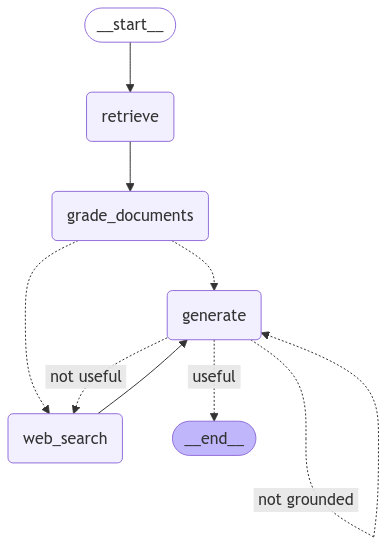

In [89]:
from IPython.display import Image

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))


In [91]:
# Run
from pprint import pprint
# inputs = {"question": "what is token manipulation attack?"}
inputs = {"question": "where to buy iphone 5?"}
for output in custom_graph.stream(inputs):
    for k, v in output.items():
        pprint(f'finished running {k}')

print(v["generation"])

---RETRIEVE---
'finished running retrieve'
'finished running grade_documents'
'finished running web_search'
'finished running generate'
You can buy an iPhone 5 from Swappa, a safe and reliable marketplace for used and refurbished devices. Alternatively, you can also find it at Walmart or Best Buy, both of which offer pre-owned options. eBay is another option where you can find great deals on new and used iPhones.
